In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm

We use the setup from Predjer et al 2010.

* $N$ workers in the platform through the period of the study, with different levels of arrival and departure
* We have $K$ time periods 
* We assume memoryless arrivals and departures, with $\lambda_k$ the arrivals at time $k$ and $\mu_k$ the departures at time $k$.
* Worker $i$ arrives (birth) at time $b_i$ and departs at time $d_i$ (both unobserved)
* Each worker has a capture history $C_i = [0 \ldots 0 1 \ldots 0 1 0 \ldots 0 0 0]$, where $H$ is a vector with $K$ binary values, and with $c_{ik}=1$ indicating that the worker $i$  appeared in the survey during the the $k$-th time period. 
* We use $u_i$ to denote the number of times that we captured the worker. 
* We use $f_i$ to denote the first time period that we see worker $i$, 
* We use $l_i$ to denote the last time period that we see worker $i$.
* We use $a_i$ for the propensity of worker $i$ to participate in the task. We assume that $a_i$ is distributed according to a Beta distribution $P(a_i) \propto B(\alpha, \beta)$.

The likelihood function for a worker that participated at least once is:

### $L_i = \sum_{s=1}^{f_i} \sum_{q=l_i}^K \lambda_s \cdot \left( \prod_{v=s}^{q-1} \left( 1 - \mu_v \right) \right) \cdot \mu_q \cdot R_i(s,q) $

where we use $s$ sum index to denote the (unobserved) arrival time, and $q$ to denote the (unobserved) departure time, with the limitation that $s$ is before $f_i$ and $q$ is after $l_i$. (So the part above gives the likelihood of arrival at $s$ and departure times.) 

Given $s$ and $q$, we know that worker $i$ has participated in $s - q$ "trials" with probability of success proportional to $a_i$. When propensity of distributed according to a Beta distribution, then the probability of observing the worker $u_i$ times follows a Beta Binomial distribution.

### $R_i(s,q) = f(u_i|n,\alpha,\beta) = \frac{\Gamma(n+1)}{\Gamma(u_i+1)\Gamma(n-u_i+1)} \frac{\Gamma(u_i+\alpha)\Gamma(n-u_i+\beta)}{\Gamma(n+\alpha+\beta)}                        \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}$

with $n = q-s+1$

-----------------------------------------

Note: When periods are months, then we are fine. If we go down to days, we will want to remover from $n = s-q$ also the "blocked" days. So, if $n=120$ days and the worker has participated 2 times, we will want to also remove 2x30=60 days.

------------------------------------


### Load data

In [2]:
# By uncommenting the lines below we allow for "eager execution"
# which is useful for debugging, as every command is executed immediately
#
# import tensorflow.contrib.eager as tfe
# tfe.enable_eager_execution()

In [3]:
df = pd.read_csv("mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')
I = len(workers)

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

K = df['period'].max() + 1

data = df.pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

data.head(10)

,count,max,min
index,,,
0,1,26,26
1,1,23,23
2,1,30,30
3,3,34,31
4,1,18,18
5,1,17,17
6,2,13,11
7,1,14,14
8,1,15,15


In [4]:
print("K (periods):", K)
print("I (workers):", I)

K (periods): 36
I (workers): 46145


### Improvements / TODO

* Make the $\mu$ amd $\lambda$ vectors to add up to 1 by definition. Set lmd[0] to be a big value (to capture the fact that many workers are already present then) and then set the rest to be all equal (for now). Do the same for the departure vector but put the big value at the end.

* Calculate the $\lambda_s \cdot \prod (1-\mu_v) \cdot \mu_q$ first for all $s$, $q$ values, and then use the masks for each user to eliminate infeasible combinations, given their first and last appearances. Modularize the process in functions.

* Calculate the R_i(s,q,u_i) as a function, so that it can be reused when calculating the R_0.



### Model setup

In [5]:
# A vector with I dimensions, describing the first time we saw each of the I observed workers
f = tf.placeholder(tf.float64, shape=[I], name="first_time_seen")  
# f = tf.constant(data['min'], name="first_time_seen")
f

<tf.Tensor 'first_time_seen:0' shape=(46145,) dtype=float64>

In [6]:
# A vector with I dimensions, describing the last time we saw each of the I observed workers
l = tf.placeholder(tf.float64, shape=[I], name="last_time_seen")  
# l = tf.constant(data['max'], name="last_time_seen")
l

<tf.Tensor 'last_time_seen:0' shape=(46145,) dtype=float64>

In [7]:
# A vector with I dimensions, describing the number of time we saw each of the I observed workers
u = tf.placeholder(tf.float64, shape=[I], name="count") 
# u = tf.constant(data['count'], name="count", dtype=tf.float64)
u

<tf.Tensor 'count:0' shape=(46145,) dtype=float64>

In [8]:
# The number of unseen workers.
# The initialization value is set to 100^2, just to be close to the observed convergence value (~9500)
Uh  = tf.get_variable( dtype=tf.float64, shape=(), name = "u_hidden", initializer=tf.constant_initializer(100) ) 
U = tf.square(Uh, name="unseen")

In [9]:
# Propensity distribution parametes (propensity ~ Beta(a,b))
# The initialization value is set to 1 and 20, just to be close to the observed convergence values (2.2 and 18.2)
a = tf.get_variable("pronensity_alpha", shape=(), dtype=tf.float64, initializer=tf.constant_initializer(np.sqrt(1))  )
a = tf.square(a)
b = tf.get_variable("pronensity_beta",  shape=(), dtype=tf.float64, initializer=tf.constant_initializer(np.sqrt(20)) )
b = tf.square(b)

In [10]:
# Arrival and departure rates
# In our likelihood lambda_s and mu_q are treated as probabilities and cannot be negative
# To ensure non-negativity, and put the values between 0..1, we will start with two unconstrained
# parameters, which we will then convert into a 0..1 variable using a tanh. 
# Then, we can use the standard unconstrained optimization on lh and mh
# We initialize variables to log(1/(K-1)) to out all variables to be 
# lh = tf.get_variable("arrivals_latent",   [K], dtype=tf.float64, initializer=tf.constant_initializer(np.log(1/(K-1))))
# mh = tf.get_variable("departures_latent", [K], dtype=tf.float64, initializer=tf.constant_initializer(np.log(1/(K-1))))


lh = tf.constant(np.ones(K) * np.log(1/(K-1)))
mh = tf.constant(np.ones(K) * np.log(1/(K-1)))

# Ensures the values lambda and mu are positive and between 0 and 1
lmd = tf.sigmoid(lh, name='arrivals')
mu  = tf.sigmoid(mh, name='departures')

### Vectorizing the implementation of likelihood

### $L_i = \sum_{s=1}^{f_i} \sum_{q=l_i}^K \lambda_s \cdot  \left( \prod_{v=s}^{q-1} \left(1 - \mu_v\right) \right) \cdot \mu_q \cdot  R_i(s,q) $

###  $R_i(s,q) = f(u_i|n,\alpha,\beta) = \frac{\Gamma(n+1)}{\Gamma(u_i+1)\Gamma(n-u_i+1)} \frac{\Gamma(u_i+\alpha)\Gamma(n-u_i+\beta)}{\Gamma(n+\alpha+\beta)}                        \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}$

with $n = q-s+1$


### Computing the Birth-Death probability for each worker

We will start by computing the probability that a given worker arrived at time $s$ and departed at time $q$.

We will store the result at a $I \times K \times K$ tensor `LD_isq`. The values in this tensor will be the product $\lambda_s \cdot  \left( \prod_{v=s}^{q-1} \left(1 - \mu_v\right) \right) \cdot \mu_q$, and will be zero for infeasible combinations of $s$ and $q$. For example, if a user was first seen at time $f$, any arrival time $s>f$ is infeasible. Similarly, for departure times.

In [11]:
# To allow for the sums of variable length s .. f_i and l_i...K, we will use binary masks
# This allows the products to be defined over a constant set of dimensions (ie. 1..K instead of 1..fi)

In [12]:
# Create masks using the values from f so that for each worker we add the lamda_s until the first appearance
s_mask = tf.sequence_mask(f+1, K)
s_mask = tf.cast(s_mask, tf.float64)

# broadcast lmd to be I x K matrix 
# replicate I times and then reshape to an I x K matrix
lambda_s = tf.reshape(tf.tile(lmd, [I]), [I,K]) 
lambda_s = tf.multiply(lambda_s, s_mask) # the mask eliminates the lambda_s that we do not care about
lambda_s

<tf.Tensor 'Mul:0' shape=(46145, 36) dtype=float64>

In [13]:
# Create masks using the values from l so that for each worker we add the mu_q from the first appearance until the end
q_mask = ~tf.sequence_mask(l, K)
q_mask = tf.cast(q_mask, tf.float64)

mu_q = tf.reshape(tf.tile(mu, [I]), [I,K]) 
mu_q = tf.multiply( mu_q  , q_mask ) 
mu_q

<tf.Tensor 'Mul_1:0' shape=(46145, 36) dtype=float64>

In [14]:
# And create a mask to calculate the product of 1-mu_v
v = np.zeros([K,K,K])
for s in np.arange(K):
    for q in np.arange(s,K):
        if s>0:
            c1 = np.zeros(s-1)
            c2 = np.ones(q-s)
            c3 = np.zeros(K-q+1)
            v[s,q]= np.concatenate((c1, c2, c3))
        else:
            c2 = np.ones(q)
            c3 = np.zeros(K-q) 
            v[s,q]= np.concatenate((c2, c3))
v_mask = tf.constant(v)


In [15]:
# Calculating m_v(s,q) = Prod_s^q-1 mu_v
# mu_v[s,q]: Probability of surviving from period s to period q-1
# if q-1<s then probability is 1
mu_v = tf.pow(1-mu, v_mask)
mu_v = tf.reduce_prod(mu_v, axis=2)
mu_v

<tf.Tensor 'Prod:0' shape=(36, 36) dtype=float64>

In [16]:
LD_isq = tf.einsum('is,sq,iq->isq', lambda_s, mu_v, mu_q)
LD_isq

<tf.Tensor 'einsum/transpose_4:0' shape=(46145, 36, 36) dtype=float64>

### Vectorizing the Beta-Binomial computation

Once we know the arrival-departure likelihoods for each user, we move on to vectorize the calculation of the Beta-Binomial likelihood $R_i(s,q)$.

We know that 

###  $R_i(s,q) = f(u_i|n,\alpha,\beta) = \frac{\Gamma(n+1)}{\Gamma(u_i+1)\Gamma(n-u_i+1)} \frac{\Gamma(u_i+\alpha)\Gamma(n-u_i+\beta)}{\Gamma(n+\alpha+\beta)}                        \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}$

with $n = q-s+1$.

In [17]:
# n = q - s + 1
n = np.zeros([K,K])
for s in range(K):
    for q in range(K):
        n[s,q] = q-s+1

n = np.clip(n,a_min=0,a_max=K+1)
# n

In [18]:
count = list(data['count'].values)

In [19]:
# n-u
n_u = np.zeros([I,K,K])
for i in range(len(count)):
    n_u[i] = n - count[i]
n_u = np.clip(n_u,a_min=0,a_max=max(count))
# n_u 

In [20]:
def transform_1d_to_3d(x, K, L):
    '''
    Takes vector x of dimensionality I and broadcast it, to return a 3d tensor,
    I x K x L, where the values of the 2d KxL matrix have the values of x[i]
    '''
    lenx = x.shape[0]
    t = tf.reshape( tf.tile ( x, [K*L]), [K,L,lenx])
    return tf.einsum("sqi -> isq", t)

# transform_1d_to_3d(u, K, K)

In [21]:
def transform_2d_to_3d(XY, Z):
    '''
    Takes matrix  x of dimensionality X * Y  and broadcast it Z times, 
    to return a 3d tensor, Z x X x Y, where the values of the 2d KxL matrix have the values of x[i]
    '''
    len_x = XY.shape[0]
    len_y = XY.shape[1]
    return tf.reshape( tf.tile ( XY , [Z,1]), [I,len_x,len_y])

# transform_2d_to_3d(sq+1, I)

In [22]:
# We compute the log of the value above, as Tensorflow does not 
# have Gamma function implemented directly but it has lgamma 
# Matrix of shape I x K (s=0..K-1)  x K (q=0..K-1)  

# tf.lgamma(n+1) 
R_isq = transform_2d_to_3d( tf.lgamma(tf.constant(n+1) ), I)
# - tf.lgamma(u+1) 
R_isq -= transform_1d_to_3d( tf.lgamma(u+1), K, K )
# - tf.lgamma(n-u+1)
R_isq -= tf.lgamma( tf.constant(n_u) + 1 )   
# + tf.lgamma(u+a) 
R_isq +=  transform_1d_to_3d(tf.lgamma(u+a), K, K)
# + tf.lgamma(n-u+b)
R_isq +=  tf.lgamma( tf.constant(n_u) + b )
# - tf.lgamma(n+a+b)
R_isq -= transform_2d_to_3d( tf.lgamma(tf.constant(n) +a+b ), I)
# + tf.lgamma(a+b - tf.lgamma(a) -tf.lgamma(b)
R_isq += tf.lgamma( a + b ) - tf.lgamma(a) - tf.lgamma(b )

# The above is the computation of the log, so we take the exponent
R_isq = tf.exp(R_isq)

In [23]:
# This is the likelihood, that the worker i, who arrived at time s and departed at time q
# also appeared u_i times in our surveys.
R_isq

<tf.Tensor 'Exp:0' shape=(46145, 36, 36) dtype=float64>

### Computing the likelihood

We now compute the likelihood $L_i$ for each worker $i$ that appeared at least once in our data.

In [24]:
# We use einsum to calculate the product of LD_isq with R_isq
# and then take the sums of likelihoods for different workers,
# sum across s and q, and return a vector with I elements
Li = tf.einsum('isq,isq->i', LD_isq, R_isq)

# Li =  tf.reduce_sum(products)
Li

<tf.Tensor 'einsum_3/transpose_2:0' shape=(46145,) dtype=float64>

### Likelihood for the never observed workers:

## $L_0 = \sum_{s=1}^{K} \sum_{q=s}^K \lambda_s \cdot \left( \prod_{v=s}^{q-1} \left( 1 - \mu_v \right) \right) \cdot \mu_q \cdot  \frac{\Gamma(n+\beta)}{\Gamma(n+\alpha+\beta)}             \frac{\Gamma(\alpha+\beta)}{\Gamma(\beta)} $

### $n=q-s+1$


In [25]:
# This is the likelihood that the worker arrived at time s and departed at time q
LD0 = tf.einsum('s,sq,q->sq', lmd, mu_v, mu)
LD0

<tf.Tensor 'einsum_4/transpose_4:0' shape=(36, 36) dtype=float64>

In [26]:
v0 = np.zeros([K,K])
for s in np.arange(K):
    c1 = np.zeros(s)
    c2 = np.ones(K-s) 
    v0[s]= np.concatenate((c1, c2))
v0_mask = tf.constant(v0)
v0_mask

<tf.Tensor 'Const_7:0' shape=(36, 36) dtype=float64>

In [27]:
# Eliminate from the matrix the combinations of s/q that do not appear
# in the sum above
LD0 = tf.multiply( LD0  , v0_mask )
LD0

<tf.Tensor 'Mul_2:0' shape=(36, 36) dtype=float64>

In [28]:
R0_sq = tf.exp(
  tf.lgamma(tf.constant(n) + b) - tf.lgamma(tf.constant(n) +a + b)
+ tf.lgamma(a + b) - tf.lgamma(b)
)
R0_sq

<tf.Tensor 'Exp_1:0' shape=(36, 36) dtype=float64>

In [29]:
# Do an element-wise product of the three matrices (as they all have the same dimensions)
# and then sum all the elements
L0 = tf.reduce_sum(LD0 * R0_sq)
L0

<tf.Tensor 'Sum:0' shape=() dtype=float64>

--------------------

### Setting up the optimization objective

In [30]:
# Once we have the individual likelihoods, we take the sum of their logs
# In our case N = I + U (all workers) and N - D = U (unseen workers)
# We use that Γ(n+1) = n!  and logGamma(n+1) = log(n!)

# We want sum(lambda)=1 and sum(mu)=1
# obj1 = tf.square(tf.reduce_sum(lmd) - 1) + tf.square(tf.reduce_sum(mu) - 1)

# These are the log-likelihood function
obj2 = tf.reduce_sum(tf.log(Li))
obj3 = U * tf.log(L0)
obj4 = tf.lgamma(I+U+1.0) - tf.lgamma(U+1.0) - tf.lgamma( tf.constant(I, dtype=tf.float64) +1.0)

# objective = 1000000*obj1 - (obj4+ obj3 +obj2) 
objective = - (obj4+ obj3 +obj2) 

objective

<tf.Tensor 'Neg:0' shape=() dtype=float64>

In [31]:
train_step = tf.train.AdamOptimizer(learning_rate=0.5).minimize(objective)

### Training the model

In [32]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
loss = []

feed_data = {
    f: np.array(data['min']),  
    l: np.array(data['max']), 
    u: np.array(data['count'])
}

In [33]:
t = tqdm(range(200))

for epoch in t: 
    _, obj_value, a_est, b_est, U_est = sess.run([train_step, objective, a, b, U], feed_dict=feed_data)
    
    
    # avg_lambda = np.mean(lmd_est)
    # avg_mu = np.mean(mu_est) 
    # std_lambda = np.std(lmd_est)
    # std_mu = np.std(mu_est)
    loss.append( {"Iteration": epoch, "Loss": obj_value, "a_est": a_est, "b_est": b_est, "U": U_est } )
    template = "{obj:10.3f} / {alpha:6.3f} / {beta:6.3f} / {u:6.3f}"
    
    if epoch % 10 == 0:
        status = template.format(
                        obj = obj_value, 
                        alpha = a_est, 
                        beta = b_est, 
                        # al = avg_lambda, 
                        # am = avg_mu, 
                        u = U_est)
        t.set_description(status)


201902.560 /  2.340 / 18.666 / 9487.666: 100%|██████████| 200/200 [01:05<00:00,  3.06it/s]


In [34]:
# We get sometimes an issue where log-likelihood becomes infinite
# This is often due to one of the Li elements becoming 0.
# The code below returns the cases that generated 0 likelihood
# 
# where = tf.equal(Li_est, tf.constant(0, dtype=tf.float64) )
# indices = tf.where(where)
#data.loc[ [x[0] for x in indices.eval()] ]

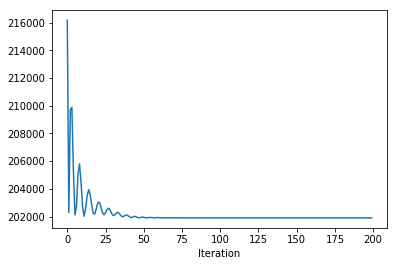

In [35]:
pd.DataFrame(loss).set_index('Iteration').Loss.plot()

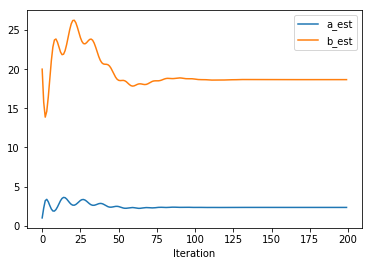

In [36]:
pd.DataFrame(loss).set_index('Iteration')[ ['a_est','b_est'] ].plot()

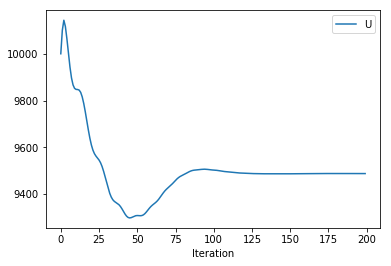

In [37]:
pd.DataFrame(loss).set_index('Iteration')[ ['U'] ].plot()